In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
## Load amygdala database
df = pd.read_csv('FCallSessions_SAD.csv')
# create a long format for analysis
df.describe()

,groupIdx,amg_hippPost1,amg_vmPFC1,amg_HippAnt1,amg_vmPFCAnt1,hippAnt_vmPFCAnt1,hippAnt_hippPost1,amg_hippPost2,amg_vmPFC2,amg_hippAnt2,...,amg_hippAnt3,amg_vmPFCAnt3,hippAnt_vmPFCAnt3,hippAnt_hippPost3,amg_hippPost4,amg_vmPFC4,amg_hippAnt4,amg_vmPFCAnt4,hippAnt_vmPFCAnt4,hippAnt_hippPost4
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,25.000000,25.000000,25.000000,...,22.000000,22.000000,22.000000,22.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.500000,0.245749,0.459820,0.320906,0.345723,0.289335,0.232288,0.253501,0.456792,0.283469,...,0.320998,0.312195,0.150924,0.225911,0.212904,0.281718,0.367485,0.239548,0.214886,0.175543
std,0.509902,0.285362,0.249508,0.235725,0.255613,0.230699,0.241149,0.267419,0.164303,0.287256,...,0.266117,0.236381,0.258439,0.285295,0.294889,0.275430,0.300589,0.286111,0.266198,0.239315
min,0.000000,-0.185759,-0.273881,-0.106130,-0.362093,-0.283361,-0.282181,-0.399358,0.156796,-0.434518,...,-0.226267,-0.082623,-0.477024,-0.205406,-0.336318,-0.270052,-0.515394,-0.405004,-0.412947,-0.379440
25%,0.000000,-0.009624,0.413321,0.129732,0.189542,0.201680,0.112753,0.111286,0.360514,0.109039,...,0.066364,0.142493,0.040574,0.017961,0.024045,0.131400,0.262697,0.124049,0.034444,0.090368
50%,0.500000,0.250243,0.511327,0.336114,0.345016,0.291861,0.215510,0.301820,0.452715,0.372298,...,0.416464,0.317829,0.145417,0.181394,0.206505,0.239333,0.432287,0.186521,0.251876,0.177151
75%,1.000000,0.419915,0.613199,0.510235,0.564029,0.380532,0.446034,0.403340,0.573483,0.445397,...,0.545097,0.506315,0.322098,0.398301,0.421366,0.515611,0.578496,0.409861,0.441137,0.343720
max,1.000000,0.733233,0.751340,0.704470,0.665214,0.710219,0.653411,0.714402,0.739009,0.664294,...,0.664938,0.676787,0.543904,0.750513,0.774437,0.648461,0.687826,0.704046,0.533626,0.488445


## Amygdala Hippocampus

In [16]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_hippPost1','amg_hippPost2',
                                                                         'amg_hippPost3'])

In [17]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                          \
                       count      mean       std       min       25%   
groupIdx variable                                                      
0        amg_hippPost1  13.0  0.239187  0.314977 -0.185759 -0.012819   
         amg_hippPost2  12.0  0.281388  0.296196 -0.399358  0.125648   
         amg_hippPost3  10.0  0.240531  0.304766 -0.177695 -0.058246   
1        amg_hippPost1  13.0  0.252310  0.265226 -0.107027 -0.000041   
         amg_hippPost2  13.0  0.227759  0.247203 -0.211711  0.111286   
         amg_hippPost3  12.0  0.287291  0.236926  0.008181  0.109627   

                                                      
                             50%       75%       max  
groupIdx variable                                     
0        amg_hippPost1  0.190872  0.486081  0.733233  
         amg_hippPost2  0.376414  0.532219  0.578719  
         amg_hippPost3  0.314022  0.465789  0.637592  
1        amg_hippPost1  0.251906  0.389394  0.703361  
         amg_hippPost2  0.254018  0.382078  0.714402  
         amg_hippPost3  0.234141  0.428418  0.718688

In [18]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value   
No. Observations:          73             Method:                    REML    
No. Groups:                26             Scale:                     0.0663  
Min. group size:           2              Log-Likelihood:            -16.3174
Max. group size:           3              Converged:                 Yes     
Mean group size:           2.8                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.239    0.077  3.095 0.002  0.088  0.391
variable[T.amg_hippPost2]           0.035    0.104  0.336 0.737 -0.168  0.238
variable[T.amg_hippPost3]          -0.004    0.109 -0.034 0.973 -0.218  0.211
groupI

In [19]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.019      1     19  0.019  0.243    0.628  0.013  nan
variable     0.004      2     38  0.002  0.028    0.972  0.001    0.942
Interaction  0.074      2     38  0.037  0.583    0.563  0.030  nan



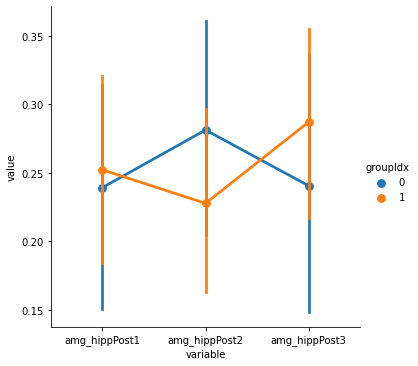

In [20]:
sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68)

In [21]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values 
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_hippPost1','amg_hippPost2','amg_hippPost3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [22]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
  
  
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 
    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

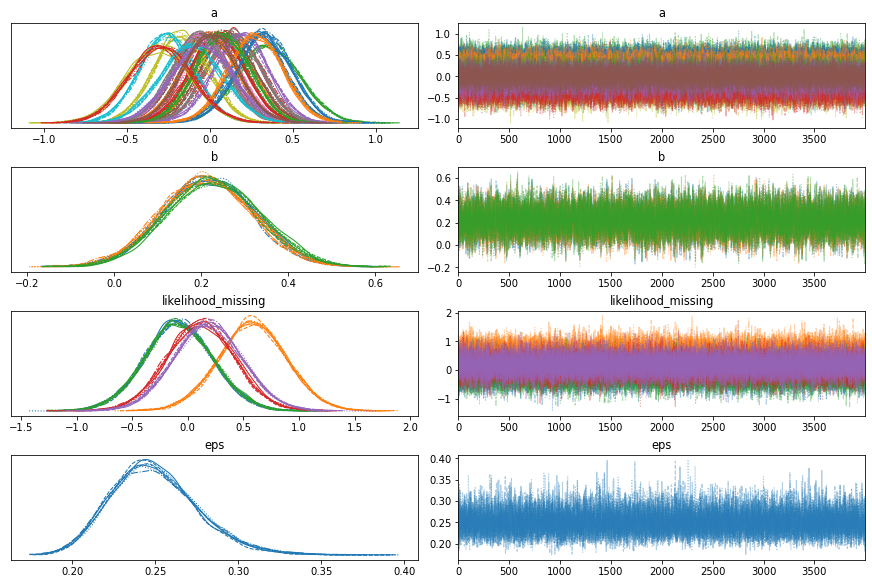

In [11]:
az.plot_trace(trace)

In [12]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.003,0.166,-0.269,0.274,0.002,0.001,12053.0,18180.0,1.0
a[1],0.088,0.166,-0.191,0.353,0.002,0.001,11984.0,18108.0,1.0
a[2],0.354,0.188,0.038,0.658,0.002,0.001,13680.0,18793.0,1.0
a[3],0.145,0.165,-0.119,0.422,0.002,0.001,11632.0,16114.0,1.0
a[4],-0.045,0.165,-0.315,0.223,0.002,0.001,11620.0,18041.0,1.0
a[5],0.109,0.167,-0.172,0.372,0.002,0.001,12134.0,18290.0,1.0
a[6],0.008,0.164,-0.269,0.270,0.002,0.001,11196.0,17047.0,1.0
a[7],0.144,0.166,-0.137,0.406,0.001,0.001,12417.0,17867.0,1.0
a[8],-0.175,0.166,-0.447,0.098,0.002,0.001,11761.0,16392.0,1.0
a[9],-0.260,0.165,-0.537,0.006,0.002,0.001,11888.0,17905.0,1.0


0.4705


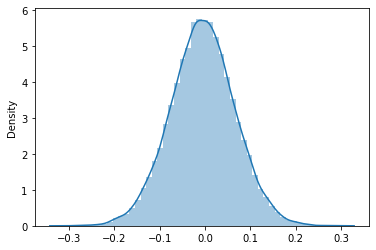

In [13]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.5548214285714286


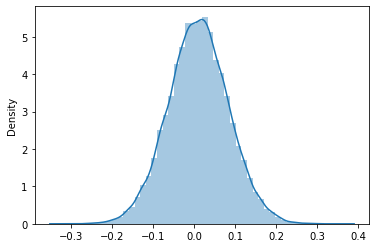

In [14]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [23]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.241,0.088,0.088,0.370,0.002,0.001,1780.0,1841.0,1.0
groupIdx,0.010,0.121,-0.195,0.200,0.003,0.002,1774.0,1910.0,1.0
sd,0.307,0.048,0.230,0.376,0.001,0.001,2020.0,1702.0,1.0


In [24]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.282,0.083,0.150,0.427,0.002,0.001,1936.0,2567.0,1.0
groupIdx,-0.054,0.113,-0.241,0.132,0.003,0.002,1810.0,2097.0,1.0
sd,0.286,0.047,0.217,0.362,0.001,0.001,1930.0,1232.0,1.0


In [25]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.240,0.092,0.088,0.386,0.002,0.002,1761.0,2244.0,1.0
groupIdx,0.049,0.124,-0.129,0.271,0.003,0.002,1673.0,2013.0,1.0
sd,0.287,0.050,0.209,0.366,0.001,0.001,1734.0,1781.0,1.0


- Between amygdala and posterior hippocampus there's no difference in the sad script FC.

## Amygdala and vmPFC

In [5]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_vmPFC1','amg_vmPFC2',
                                                                         'amg_vmPFC3'])

In [7]:
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                    count      mean       std       min       25%       50%   
groupIdx variable                                                             
0        amg_vmPFC1  13.0  0.526904  0.188009  0.022799  0.479649  0.531321   
         amg_vmPFC2  12.0  0.470152  0.167646  0.156796  0.401734  0.469405   
         amg_vmPFC3  10.0  0.495021  0.194920  0.063593  0.433717  0.533812   
1        amg_vmPFC1  13.0  0.392737  0.290858 -0.273881  0.239379  0.463336   
         amg_vmPFC2  13.0  0.444459  0.166988  0.211781  0.352188  0.414529   
         amg_vmPFC3  12.0  0.369794  0.240783 -0.112596  0.246810  0.403426   

                                         
                          75%       max  
groupIdx variable                        
0        amg_vmPFC1  0.643805  0.751340  
         amg_vmPFC2  0.556209  0.739009  
         amg_vmPFC3  0.618081  0.750531  
1        amg_vmPFC1  0.576644  0.738186  
         amg_vmPFC2  0.580113  0.689707  
         amg_vmPFC3  0.533126  0.711514

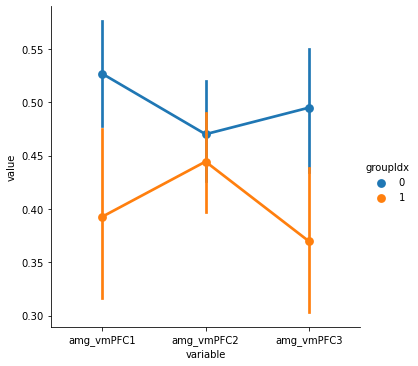

In [20]:
sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point',
           ci=68)

In [21]:
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.144      1     19  0.144  2.409    0.137  0.113  nan
variable     0.048      2     38  0.024  0.599    0.554  0.031    0.900
Interaction  0.056      2     38  0.028  0.697    0.505  0.035  nan



In [22]:
glm = smf.mixedlm('value ~ variable + groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value 
No. Observations:      73          Method:                 REML  
No. Groups:            26          Scale:                  0.0381
Min. group size:       2           Log-Likelihood:         3.5356
Max. group size:       3           Converged:              Yes   
Mean group size:       2.8                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.507    0.050 10.055 0.000  0.408  0.606
variable[T.amg_vmPFC2]  0.001    0.055  0.023 0.982 -0.106  0.109
variable[T.amg_vmPFC3] -0.033    0.057 -0.583 0.560 -0.145  0.079
groupIdx               -0.094    0.057 -1.661 0.097 -0.205  0.017
Group Var               0.007    0.038                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [10]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
 
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

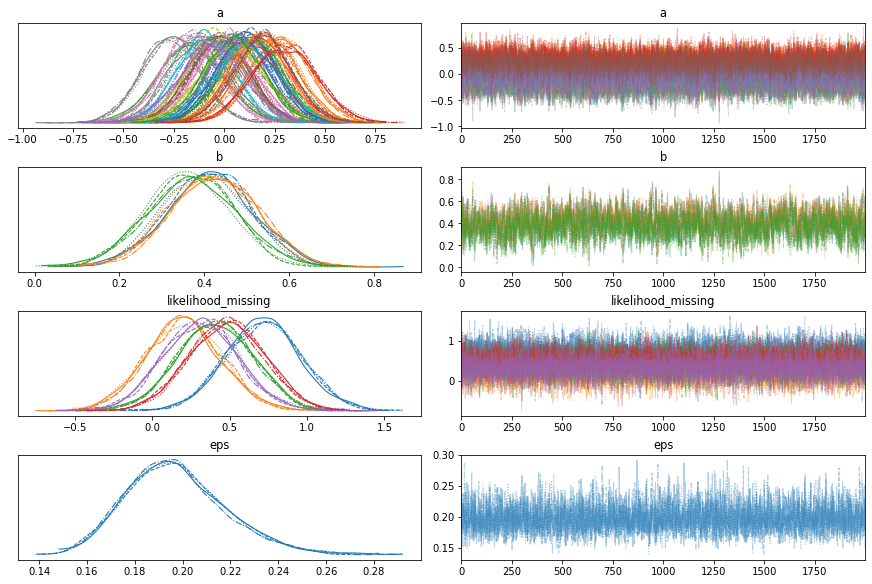

In [11]:
az.plot_trace(trace)

In [26]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.122,0.145,-0.114,0.362,0.002,0.001,8924.0,16365.0,1.0
a[1],0.283,0.146,0.050,0.528,0.002,0.001,8491.0,15486.0,1.0
a[2],-0.166,0.164,-0.435,0.104,0.002,0.001,9591.0,18622.0,1.0
a[3],0.119,0.146,-0.125,0.358,0.002,0.001,8769.0,14944.0,1.0
a[4],-0.047,0.146,-0.280,0.199,0.002,0.001,9018.0,16668.0,1.0
a[5],-0.014,0.146,-0.258,0.224,0.002,0.001,8969.0,16136.0,1.0
a[6],-0.164,0.146,-0.410,0.069,0.002,0.001,8706.0,16619.0,1.0
a[7],-0.262,0.146,-0.501,-0.019,0.002,0.001,8762.0,15216.0,1.0
a[8],-0.041,0.146,-0.281,0.200,0.002,0.001,8835.0,15164.0,1.0
a[9],-0.091,0.145,-0.331,0.144,0.002,0.001,8837.0,16098.0,1.0


0.54415625


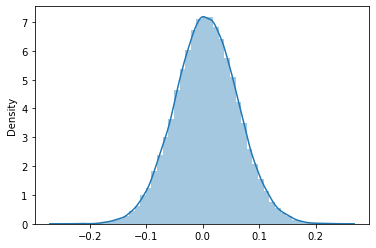

In [27]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.21628125


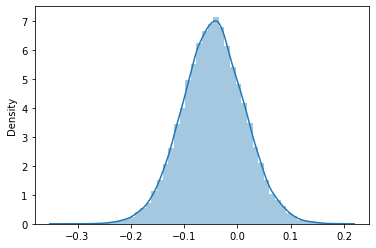

In [28]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

Differences between groups

In [12]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.527,0.074,0.402,0.647,0.002,0.001,1936.0,1985.0,1.0
groupIdx,-0.135,0.107,-0.308,0.041,0.002,0.002,1953.0,2111.0,1.0
sd,0.260,0.041,0.194,0.325,0.001,0.001,1845.0,1857.0,1.0


In [13]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.468,0.054,0.379,0.553,0.001,0.001,1938.0,1802.0,1.0
groupIdx,-0.024,0.075,-0.146,0.096,0.002,0.001,1865.0,1722.0,1.0
sd,0.177,0.029,0.134,0.223,0.001,0.000,1655.0,1898.0,1.0


In [14]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.494,0.077,0.372,0.622,0.002,0.001,1796.0,2077.0,1.0
groupIdx,-0.123,0.105,-0.292,0.048,0.003,0.002,1620.0,1836.0,1.0
sd,0.236,0.041,0.172,0.297,0.001,0.001,2013.0,2003.0,1.0


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'groupIdx'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

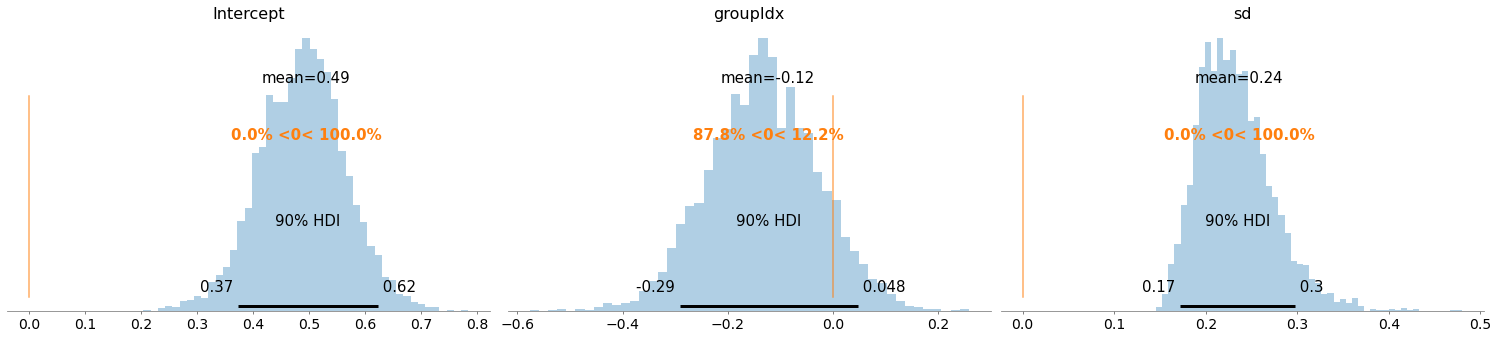

In [15]:
az.plot_posterior(traceSes3, hdi_prob=.9, ref_val=0, kind='hist')